## RF PatternTraces

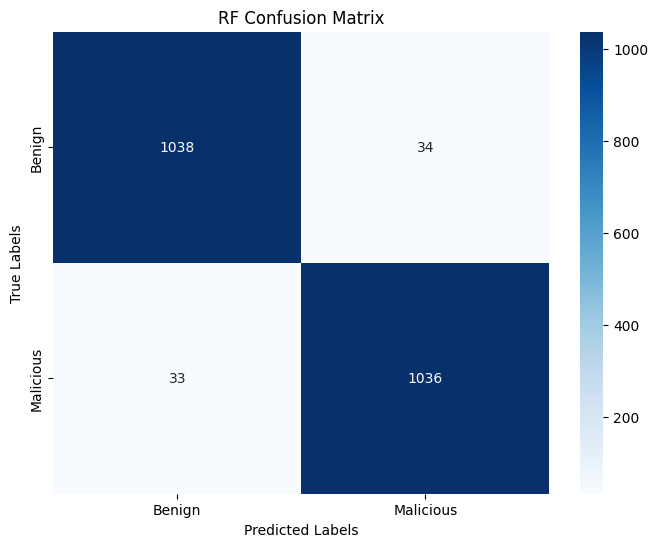

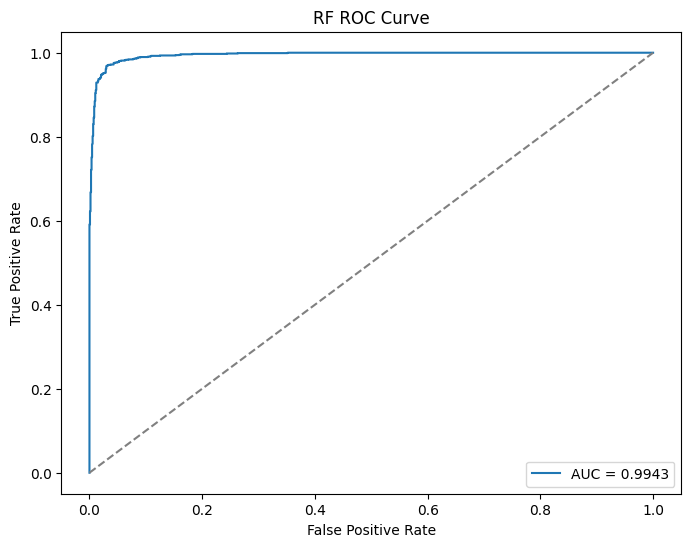

Train Accuracy: 0.97447192
Validation Accuracy: 0.96823914
Test Accuracy: 0.96870621
Precision: 0.96870666
Recall: 0.96870621
F1 Score: 0.96870623
ROC AUC: 0.99425944
Cohen's Kappa: 0.93741238
Training Time (s): 0.59916139
Validation Time (s): 0.03222394
Test Time (s): 0.03199124
Model saved at: RF_best_model_ngrams.pkl


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_fscore_support, cohen_kappa_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Load dataset
file_path = 'D:/Final Version/Step 14 CombinedTraces/CombinedDataset/FinalCombinedBenignMaliciousDataset-v3.csv'
data = pd.read_csv(file_path)

# Remove 'Package_Name' column if present
if 'Package_Name' in data.columns:
    data = data.drop(columns=['Package_Name'])

# Combine categorical columns into a single text feature
categorical_columns = [col for col in data.columns if data[col].dtype == 'object' and col != 'Level']
data['Combined_Categorical'] = data[categorical_columns].fillna('').astype(str).agg(' '.join, axis=1)

# Vectorize the combined categorical text column using n-grams
vectorizer = CountVectorizer(ngram_range=(2, 3))
categorical_ngrams = vectorizer.fit_transform(data['Combined_Categorical'])

# Ensure only valid numeric columns are selected
numerical_columns = [
    col for col in data.columns
    if pd.to_numeric(data[col], errors='coerce').notnull().all() and col != 'Level'
]

# Prepare numerical features
numerical_features = data[numerical_columns].fillna(0).astype(float)

# Convert numerical features to sparse matrix
numerical_features_sparse = csr_matrix(numerical_features.values)

# Combine numerical features with n-gram features
X = hstack([numerical_features_sparse, categorical_ngrams])

# Scale features before combining
scaler = StandardScaler(with_mean=False)  # Sparse matrices need `with_mean=False`
X_scaled = scaler.fit_transform(X)

# Define the target variable
y = data['Level']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


# Initialize Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=10,  # Fewer trees
    max_depth=10,      # Limit tree depth
    random_state=42
)

# Train the model and record training time
start_train_time = time.time()
rf_model.fit(X_train, y_train)
train_time = time.time() - start_train_time

# Predictions
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# Calculate AUC for test set
y_test_prob = rf_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_prob)

# Confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_test_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_test_pred)

# Record validation and test times
start_val_time = time.time()
rf_model.predict(X_val)
val_time = time.time() - start_val_time

start_test_time = time.time()
rf_model.predict(X_test)
test_time = time.time() - start_test_time

# Save the model
model_path = 'RF_best_model_ngrams.pkl'
joblib.dump(rf_model, model_path)

# Visualizations and saving plots
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title('RF Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('RF Confusion Matrix.png')  # Save the plot
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('RF ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('RF ROC Curve.png')  # Save the plot
plt.show()

# Print metrics
metrics = {
    "Train Accuracy": train_acc,
    "Validation Accuracy": val_acc,
    "Test Accuracy": test_acc,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": test_auc,
    "Cohen's Kappa": kappa,
    "Training Time (s)": train_time,
    "Validation Time (s)": val_time,
    "Test Time (s)": test_time,
}
for metric, value in metrics.items():
    print(f"{metric}: {value:.8f}")

print(f"Model saved at: {model_path}")

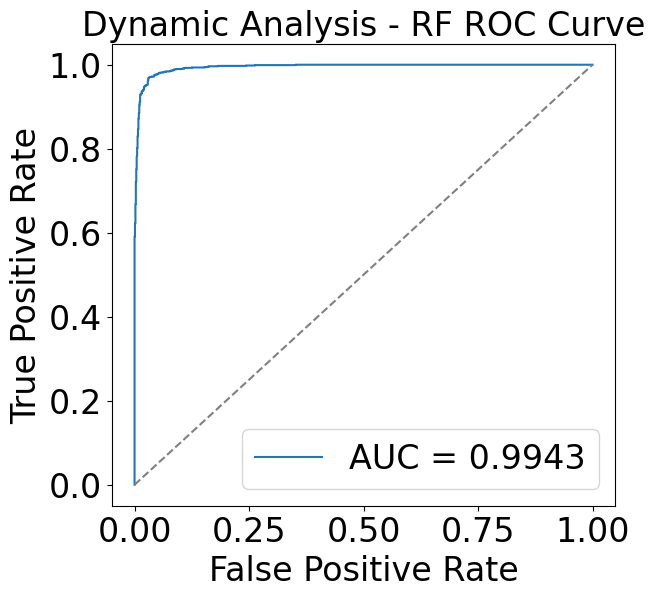

In [16]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(6.5, 6))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Dynamic Analysis - RF ROC Curve', fontsize=24)  # Increase title font size
plt.xlabel('False Positive Rate', fontsize=24)  # Increase x-axis label font size
plt.ylabel('True Positive Rate', fontsize=24)  # Increase y-axis label font size
plt.legend(fontsize=24)  # Increase legend font size
plt.tick_params(axis='both', labelsize=24)  # Increase tick font size
plt.savefig('RF ROC Curve.png', bbox_inches='tight')  # Save the full plot
plt.show()

## DT PatternTraces

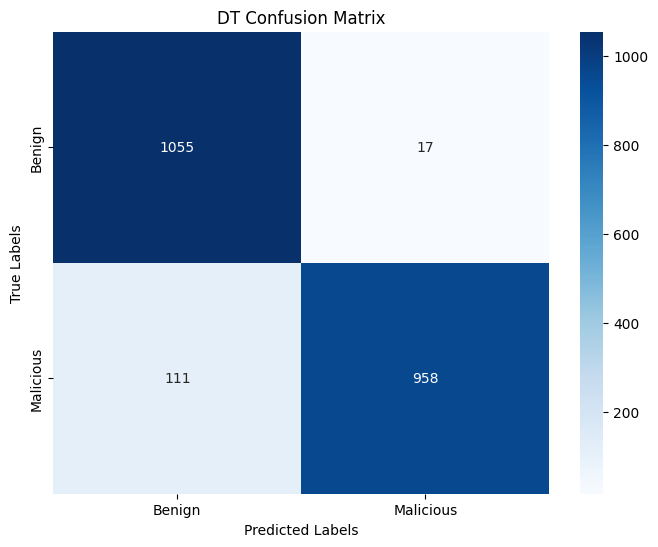

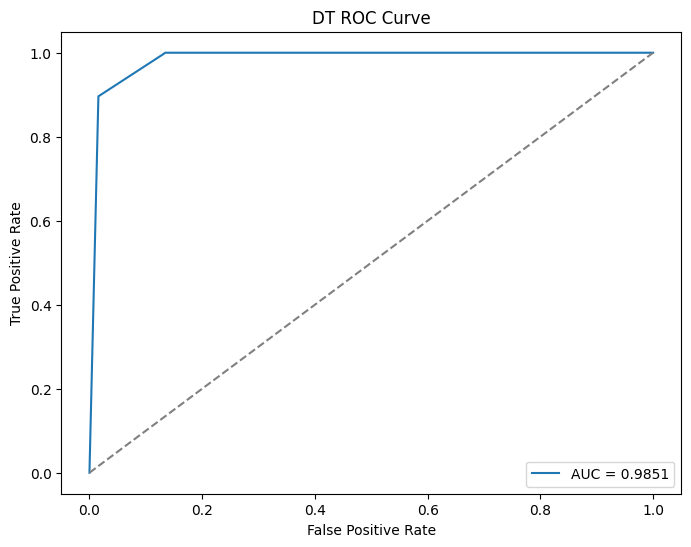

Train Accuracy: 0.93893283
Validation Accuracy: 0.93881364
Test Accuracy: 0.94021485
Precision: 0.94362894
Recall: 0.94021485
F1 Score: 0.94009569
ROC AUC: 0.98506895
Cohen's Kappa: 0.88041476
Training Time (s): 6.30585122
Validation Time (s): 0.04130960
Test Time (s): 0.03888774
Model saved at: DT_best_model_ngrams.pkl


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_fscore_support, cohen_kappa_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Load dataset
file_path = 'D:/Final Version/Step 14 CombinedTraces/CombinedDataset/FinalCombinedBenignMaliciousDataset-v3.csv'
data = pd.read_csv(file_path)

# Remove 'Package_Name' column if present
if 'Package_Name' in data.columns:
    data = data.drop(columns=['Package_Name'])

# Combine categorical columns into a single text feature
categorical_columns = [col for col in data.columns if data[col].dtype == 'object' and col != 'Level']
data['Combined_Categorical'] = data[categorical_columns].fillna('').astype(str).agg(' '.join, axis=1)

# Vectorize the combined categorical text column using n-grams
vectorizer = CountVectorizer(ngram_range=(2, 3))
categorical_ngrams = vectorizer.fit_transform(data['Combined_Categorical'])

# Ensure only valid numeric columns are selected
numerical_columns = [
    col for col in data.columns
    if pd.to_numeric(data[col], errors='coerce').notnull().all() and col != 'Level'
]

# Prepare numerical features
numerical_features = data[numerical_columns].fillna(0).astype(float)

# Convert numerical features to sparse matrix
numerical_features_sparse = csr_matrix(numerical_features.values)

# Combine numerical features with n-gram features
X = hstack([numerical_features_sparse, categorical_ngrams])

# Scale features before combining
scaler = StandardScaler(with_mean=False)  # Sparse matrices need `with_mean=False`
X_scaled = scaler.fit_transform(X)

# Define the target variable
y = data['Level']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Initialize Decision Tree model
dt_model = DecisionTreeClassifier(
    max_depth=2,           # Shallow tree
    min_samples_split=20,  # Require more samples to split a node
    random_state=42
)

# Train the model and record training time
start_train_time = time.time()
dt_model.fit(X_train, y_train)
train_time = time.time() - start_train_time

# Predictions
y_train_pred = dt_model.predict(X_train)
y_val_pred = dt_model.predict(X_val)
y_test_pred = dt_model.predict(X_test)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# Calculate AUC for test set
y_test_prob = dt_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_prob)

# Confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_test_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_test_pred)

# Record validation and test times
start_val_time = time.time()
dt_model.predict(X_val)
val_time = time.time() - start_val_time

start_test_time = time.time()
dt_model.predict(X_test)
test_time = time.time() - start_test_time

# Save the model
model_path = 'DT_best_model_ngrams.pkl'
joblib.dump(dt_model, model_path)

# Visualizations and saving plots
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title('DT Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('DT Confusion Matrix.png')  # Save the plot
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('DT ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('DT ROC Curve.png')  # Save the plot
plt.show()

# Print metrics
metrics = {
    "Train Accuracy": train_acc,
    "Validation Accuracy": val_acc,
    "Test Accuracy": test_acc,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": test_auc,
    "Cohen's Kappa": kappa,
    "Training Time (s)": train_time,
    "Validation Time (s)": val_time,
    "Test Time (s)": test_time,
}
for metric, value in metrics.items():
    print(f"{metric}: {value:.8f}")

print(f"Model saved at: {model_path}")

## SVM PatternTraces

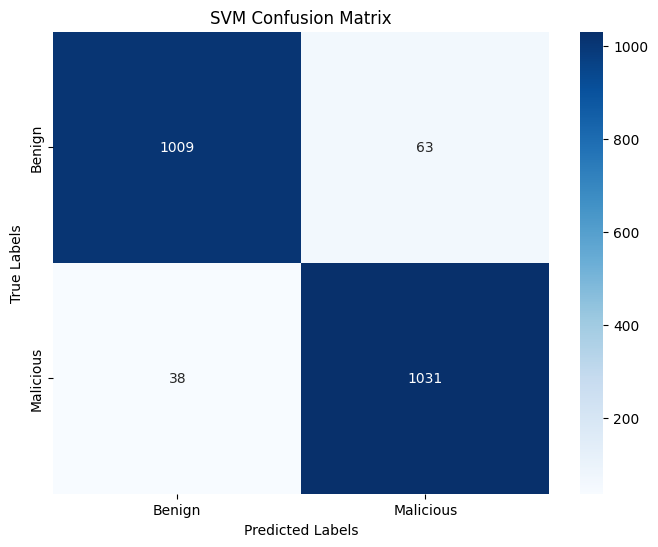

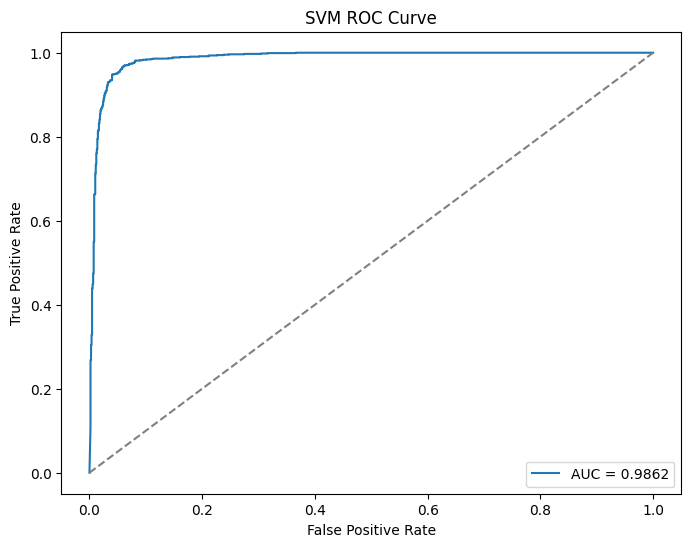

Train Accuracy: 0.95184703
Validation Accuracy: 0.94908921
Test Accuracy: 0.95282578
Precision: 0.95307441
Recall: 0.95282578
F1 Score: 0.95282012
ROC AUC: 0.98624133
Cohen's Kappa: 0.90565447
Training Time (s): 16181.15901852
Validation Time (s): 8.43745995
Test Time (s): 8.41514134
Model saved at: SVM_best_model_ngrams.pkl


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_fscore_support, cohen_kappa_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Load dataset
file_path = 'D:/Final Version/Step 14 CombinedTraces/CombinedDataset/FinalCombinedBenignMaliciousDataset-v3.csv'
data = pd.read_csv(file_path)

# Remove 'Package_Name' column if present
if 'Package_Name' in data.columns:
    data = data.drop(columns=['Package_Name'])

# Combine categorical columns into a single text feature
categorical_columns = [col for col in data.columns if data[col].dtype == 'object' and col != 'Level']
data['Combined_Categorical'] = data[categorical_columns].fillna('').astype(str).agg(' '.join, axis=1)

# Vectorize the combined categorical text column using n-grams
vectorizer = CountVectorizer(ngram_range=(2, 3))
categorical_ngrams = vectorizer.fit_transform(data['Combined_Categorical'])

# Ensure only valid numeric columns are selected
numerical_columns = [
    col for col in data.columns
    if pd.to_numeric(data[col], errors='coerce').notnull().all() and col != 'Level'
]

# Prepare numerical features
numerical_features = data[numerical_columns].fillna(0).astype(float)

# Convert numerical features to sparse matrix
numerical_features_sparse = csr_matrix(numerical_features.values)

# Combine numerical features with n-gram features
X = hstack([numerical_features_sparse, categorical_ngrams])

# Define the target variable
y = data['Level']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Initialize SVM model with probability=True for AUC/ROC calculations
svm_model = SVC(kernel='linear', probability=True, random_state=42)

# Train the model and record training time
start_train_time = time.time()
svm_model.fit(X_train, y_train)
train_time = time.time() - start_train_time

# Predictions
y_train_pred = svm_model.predict(X_train)
y_val_pred = svm_model.predict(X_val)
y_test_pred = svm_model.predict(X_test)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# Calculate AUC for test set
y_test_prob = svm_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_prob)

# Confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_test_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_test_pred)

# Record validation and test times
start_val_time = time.time()
svm_model.predict(X_val)
val_time = time.time() - start_val_time

start_test_time = time.time()
svm_model.predict(X_test)
test_time = time.time() - start_test_time

# Save the model
model_path = 'SVM_best_model_ngrams.pkl'
joblib.dump(svm_model, model_path)

# Visualizations and saving plots
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('SVM Confusion Matrix.png')  # Save the plot
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('SVM ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('SVM ROC Curve.png')  # Save the plot
plt.show()

# Print metrics
metrics = {
    "Train Accuracy": train_acc,
    "Validation Accuracy": val_acc,
    "Test Accuracy": test_acc,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": test_auc,
    "Cohen's Kappa": kappa,
    "Training Time (s)": train_time,
    "Validation Time (s)": val_time,
    "Test Time (s)": test_time,
}
for metric, value in metrics.items():
    print(f"{metric}: {value:.8f}")

print(f"Model saved at: {model_path}")


## LR PatternTraces

C:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


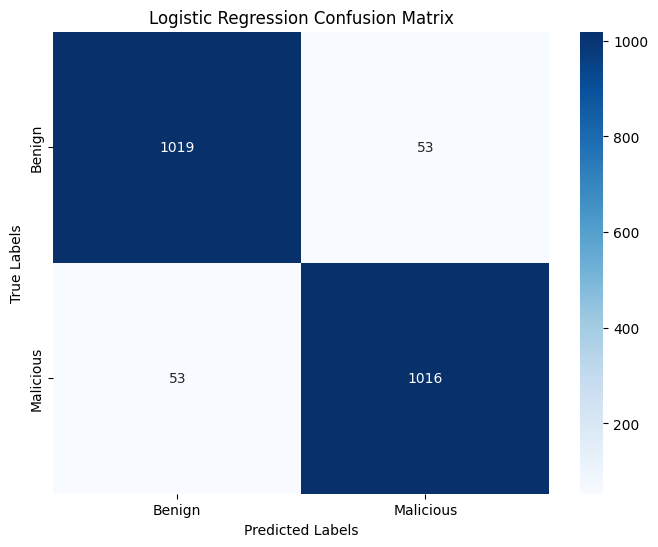

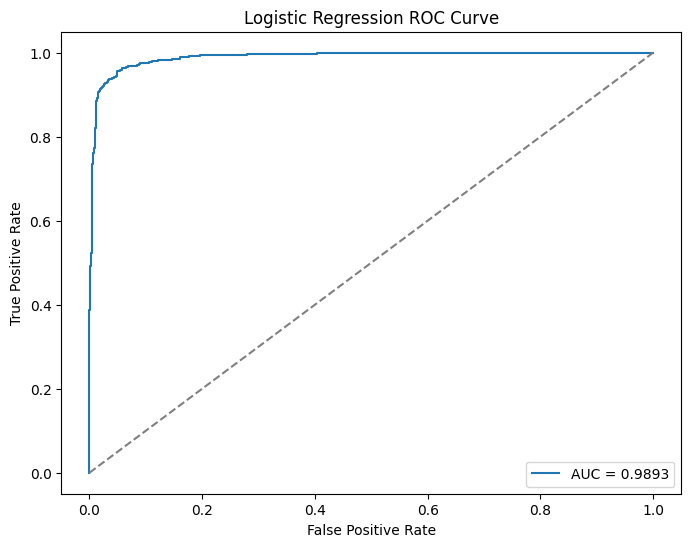

Train Accuracy: 0.94734208
Validation Accuracy: 0.95282578
Test Accuracy: 0.95049043
Precision: 0.95049043
Recall: 0.95049043
F1 Score: 0.95049043
ROC AUC: 0.98934263
Cohen's Kappa: 0.90098066
Training Time (s): 113.88944364
Validation Time (s): 0.00101066
Test Time (s): 0.00100875
Model saved at: LR_best_model_ngrams.pkl


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_fscore_support, cohen_kappa_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Load dataset
file_path = 'D:/Final Version/Step 14 CombinedTraces/CombinedDataset/FinalCombinedBenignMaliciousDataset-v3.csv'
data = pd.read_csv(file_path)

# Remove 'Package_Name' column if present
if 'Package_Name' in data.columns:
    data = data.drop(columns=['Package_Name'])

# Combine categorical columns into a single text feature
categorical_columns = [col for col in data.columns if data[col].dtype == 'object' and col != 'Level']
data['Combined_Categorical'] = data[categorical_columns].fillna('').astype(str).agg(' '.join, axis=1)

# Vectorize the combined categorical text column using n-grams
vectorizer = CountVectorizer(ngram_range=(2, 3))
categorical_ngrams = vectorizer.fit_transform(data['Combined_Categorical'])

# Ensure only valid numeric columns are selected
numerical_columns = [
    col for col in data.columns
    if pd.to_numeric(data[col], errors='coerce').notnull().all() and col != 'Level'
]

# Prepare numerical features
numerical_features = data[numerical_columns].fillna(0).astype(float)

# Convert numerical features to sparse matrix
numerical_features_sparse = csr_matrix(numerical_features.values)

# Combine numerical features with n-gram features
X = hstack([numerical_features_sparse, categorical_ngrams])

# Define the target variable
y = data['Level']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Initialize Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=2500)

# Train the model and record training time
start_train_time = time.time()
lr_model.fit(X_train, y_train)
train_time = time.time() - start_train_time

# Predictions
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)
y_test_pred = lr_model.predict(X_test)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# Calculate AUC for test set
y_test_prob = lr_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_prob)

# Confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_test_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_test_pred)

# Record validation and test times
start_val_time = time.time()
lr_model.predict(X_val)
val_time = time.time() - start_val_time

start_test_time = time.time()
lr_model.predict(X_test)
test_time = time.time() - start_test_time

# Save the model
model_path = 'LR_best_model_ngrams.pkl'
joblib.dump(lr_model, model_path)

# Visualizations and saving plots
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('Logistic Regression Confusion Matrix.png')  # Save the plot
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Logistic Regression ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('Logistic Regression ROC Curve.png')  # Save the plot
plt.show()

# Print metrics
metrics = {
    "Train Accuracy": train_acc,
    "Validation Accuracy": val_acc,
    "Test Accuracy": test_acc,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": test_auc,
    "Cohen's Kappa": kappa,
    "Training Time (s)": train_time,
    "Validation Time (s)": val_time,
    "Test Time (s)": test_time,
}
for metric, value in metrics.items():
    print(f"{metric}: {value:.8f}")

print(f"Model saved at: {model_path}")


## KNN Pattern Traces

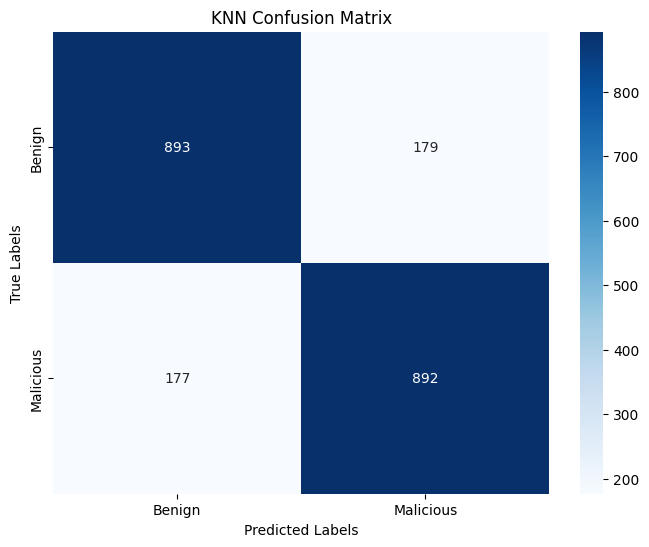

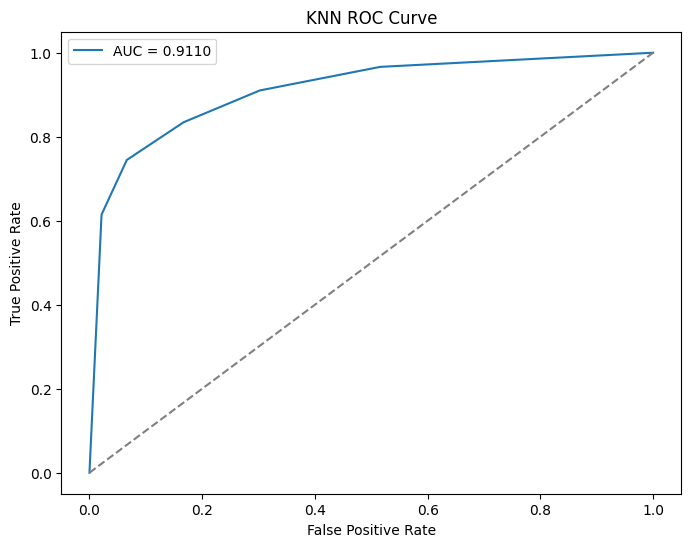

Train Accuracy: 0.88056863
Validation Accuracy: 0.83559085
Test Accuracy: 0.83372256
Precision: 0.83372416
Recall: 0.83372256
F1 Score: 0.83372263
ROC AUC: 0.91097483
Cohen's Kappa: 0.66744534
Training Time (s): 0.00949645
Validation Time (s): 2.99635196
Test Time (s): 2.67500424
Model saved at: KNN_best_model_ngrams.pkl


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_fscore_support, cohen_kappa_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Load dataset
file_path = 'D:/Final Version/Step 14 CombinedTraces/CombinedDataset/FinalCombinedBenignMaliciousDataset-v3.csv'
data = pd.read_csv(file_path)

# Remove 'Package_Name' column if present
if 'Package_Name' in data.columns:
    data = data.drop(columns=['Package_Name'])

# Combine categorical columns into a single text feature
categorical_columns = [col for col in data.columns if data[col].dtype == 'object' and col != 'Level']
data['Combined_Categorical'] = data[categorical_columns].fillna('').astype(str).agg(' '.join, axis=1)

# Vectorize the combined categorical text column using n-grams
vectorizer = CountVectorizer(ngram_range=(2, 3))
categorical_ngrams = vectorizer.fit_transform(data['Combined_Categorical'])

# Ensure only valid numeric columns are selected
numerical_columns = [
    col for col in data.columns
    if pd.to_numeric(data[col], errors='coerce').notnull().all() and col != 'Level'
]

# Prepare numerical features
numerical_features = data[numerical_columns].fillna(0).astype(float)

# Convert numerical features to sparse matrix
numerical_features_sparse = csr_matrix(numerical_features.values)

# Combine numerical features with n-gram features
X = hstack([numerical_features_sparse, categorical_ngrams])

# Define the target variable
y = data['Level']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Initialize KNN model with k=5
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model and record training time
start_train_time = time.time()
knn_model.fit(X_train, y_train)
train_time = time.time() - start_train_time

# Predictions
y_train_pred = knn_model.predict(X_train)
y_val_pred = knn_model.predict(X_val)
y_test_pred = knn_model.predict(X_test)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# Calculate AUC for test set
y_test_prob = knn_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_prob)

# Confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_test_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_test_pred)

# Record validation and test times
start_val_time = time.time()
knn_model.predict(X_val)
val_time = time.time() - start_val_time

start_test_time = time.time()
knn_model.predict(X_test)
test_time = time.time() - start_test_time

# Save the model
model_path = 'KNN_best_model_ngrams.pkl'
joblib.dump(knn_model, model_path)

# Visualizations and saving plots
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('KNN Confusion Matrix.png')  # Save the plot
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('KNN ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('KNN ROC Curve.png')  # Save the plot
plt.show()

# Print metrics
metrics = {
    "Train Accuracy": train_acc,
    "Validation Accuracy": val_acc,
    "Test Accuracy": test_acc,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": test_auc,
    "Cohen's Kappa": kappa,
    "Training Time (s)": train_time,
    "Validation Time (s)": val_time,
    "Test Time (s)": test_time,
}
for metric, value in metrics.items():
    print(f"{metric}: {value:.8f}")

print(f"Model saved at: {model_path}")


## GB Pattern Traces

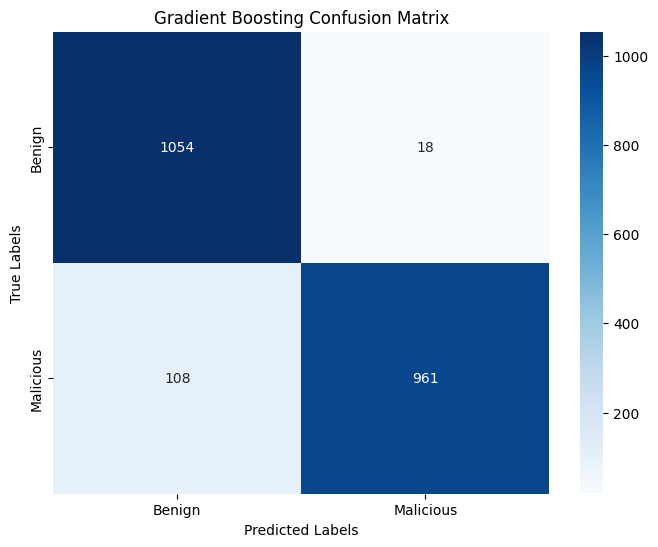

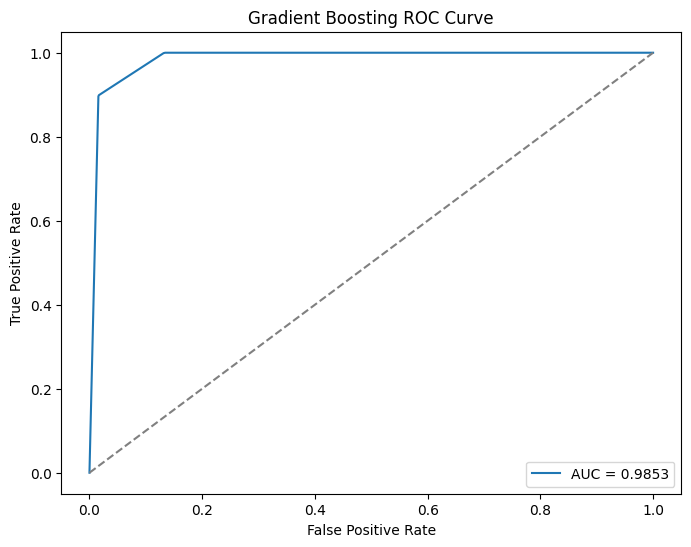

Train Accuracy: 0.93943338
Validation Accuracy: 0.94021485
Test Accuracy: 0.94114900
Precision: 0.94428311
Recall: 0.94114900
F1 Score: 0.94104133
ROC AUC: 0.98530107
Cohen's Kappa: 0.88228389
Training Time (s): 46.96303129
Validation Time (s): 0.02770782
Test Time (s): 0.02558088
Model saved at: GB_best_model_ngrams.pkl


In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_fscore_support, cohen_kappa_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Load dataset
file_path = 'D:/Final Version/Step 14 CombinedTraces/CombinedDataset/FinalCombinedBenignMaliciousDataset-v3.csv'
data = pd.read_csv(file_path)

# Remove 'Package_Name' column if present
if 'Package_Name' in data.columns:
    data = data.drop(columns=['Package_Name'])

# Combine categorical columns into a single text feature
categorical_columns = [col for col in data.columns if data[col].dtype == 'object' and col != 'Level']
data['Combined_Categorical'] = data[categorical_columns].fillna('').astype(str).agg(' '.join, axis=1)

# Vectorize the combined categorical text column using n-grams
vectorizer = CountVectorizer(ngram_range=(2, 3))
categorical_ngrams = vectorizer.fit_transform(data['Combined_Categorical'])

# Ensure only valid numeric columns are selected
numerical_columns = [
    col for col in data.columns
    if pd.to_numeric(data[col], errors='coerce').notnull().all() and col != 'Level'
]

# Prepare numerical features
numerical_features = data[numerical_columns].fillna(0).astype(float)

# Convert numerical features to sparse matrix
numerical_features_sparse = csr_matrix(numerical_features.values)

# Combine numerical features with n-gram features
X = hstack([numerical_features_sparse, categorical_ngrams])

# Define the target variable
y = data['Level']

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Initialize Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=10,         # Fewer trees
    max_depth=2,             # Shallow trees
    learning_rate=0.01,      # Small learning rate
    random_state=42
)

# Train the model and record training time
start_train_time = time.time()
gb_model.fit(X_train, y_train)
train_time = time.time() - start_train_time

# Predictions
y_train_pred = gb_model.predict(X_train)
y_val_pred = gb_model.predict(X_val)
y_test_pred = gb_model.predict(X_test)

# Calculate accuracies
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# Calculate AUC for test set
y_test_prob = gb_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_prob)

# Confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_test_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_test_pred)

# Record validation and test times
start_val_time = time.time()
gb_model.predict(X_val)
val_time = time.time() - start_val_time

start_test_time = time.time()
gb_model.predict(X_test)
test_time = time.time() - start_test_time

# Save the model
model_path = 'GB_best_model_ngrams.pkl'
joblib.dump(gb_model, model_path)

# Visualizations and saving plots
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('Gradient Boosting Confusion Matrix.png')  # Save the plot
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Gradient Boosting ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('Gradient Boosting ROC Curve.png')  # Save the plot
plt.show()

# Print metrics
metrics = {
    "Train Accuracy": train_acc,
    "Validation Accuracy": val_acc,
    "Test Accuracy": test_acc,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": test_auc,
    "Cohen's Kappa": kappa,
    "Training Time (s)": train_time,
    "Validation Time (s)": val_time,
    "Test Time (s)": test_time,
}
for metric, value in metrics.items():
    print(f"{metric}: {value:.8f}")

print(f"Model saved at: {model_path}")


In [32]:
# Updated metrics for new data
updated_metrics = {
    "Model": ["Random Forest", "Decision Tree", "SVM", "Logistic Regression", "KNN", "Gradient Boosting"],
    "Train Accuracy": [0.96869890, 0.93893283, 0.95184703, 0.94734208, 0.88056863, 0.93943338],
    "Validation Accuracy": [0.96356356, 0.93881364, 0.94908921, 0.95282578, 0.83559085, 0.94021485],
    "Test Accuracy": [0.95995996, 0.94021485, 0.95282578, 0.95049043, 0.83372256, 0.94114900],
    "Precision": [0.96007708, 0.94362894, 0.95307441, 0.95049043, 0.83372416, 0.94428311],
    "Recall": [0.95995996, 0.94021485, 0.95282578, 0.95049043, 0.83372256, 0.94114900],
    "F1 Score": [0.95995694, 0.94009569, 0.95282012, 0.95049043, 0.83372263, 0.94104133],
    "ROC AUC": [0.99370340, 0.98506895, 0.98624133, 0.98934263, 0.91097483, 0.98530107],
    "Cohen's Kappa": [0.91991797, 0.88041476, 0.90565447, 0.90098066, 0.66744534, 0.88228389],
    "Training Time (s)": [0.49404526, 6.30585122, 16181.15901852, 113.88944364, 0.00949645, 46.96303129],
    "Validation Time (s)": [0.15122843, 0.04130960, 8.43745995, 0.00101066, 2.99635196, 0.02770782],
    "Test Time (s)": [0.11838794, 0.03888774, 8.41514134, 0.00100875, 2.67500424, 0.02558088],
}

# Convert the dictionary to a DataFrame
updated_results_df = pd.DataFrame(updated_metrics)

# Save the DataFrame to a CSV file
updated_csv_file_path = "model_comparison_results.csv"
updated_results_df.to_csv(updated_csv_file_path, index=False)
updated_results_df

,Model,Train Accuracy,Validation Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC AUC,Cohen's Kappa,Training Time (s),Validation Time (s),Test Time (s)
0,Random Forest,0.968699,0.963564,0.959960,0.960077,0.959960,0.959957,0.993703,0.919918,0.494045,0.151228,0.118388
1,Decision Tree,0.938933,0.938814,0.940215,0.943629,0.940215,0.940096,0.985069,0.880415,6.305851,0.041310,0.038888
2,SVM,0.951847,0.949089,0.952826,0.953074,0.952826,0.952820,0.986241,0.905654,16181.159019,8.437460,8.415141
3,Logistic Regression,0.947342,0.952826,0.950490,0.950490,0.950490,0.950490,0.989343,0.900981,113.889444,0.001011,0.001009
4,KNN,0.880569,0.835591,0.833723,0.833724,0.833723,0.833723,0.910975,0.667445,0.009496,2.996352,2.675004
5,Gradient Boosting,0.939433,0.940215,0.941149,0.944283,0.941149,0.941041,0.985301,0.882284,46.963031,0.027708,0.025581


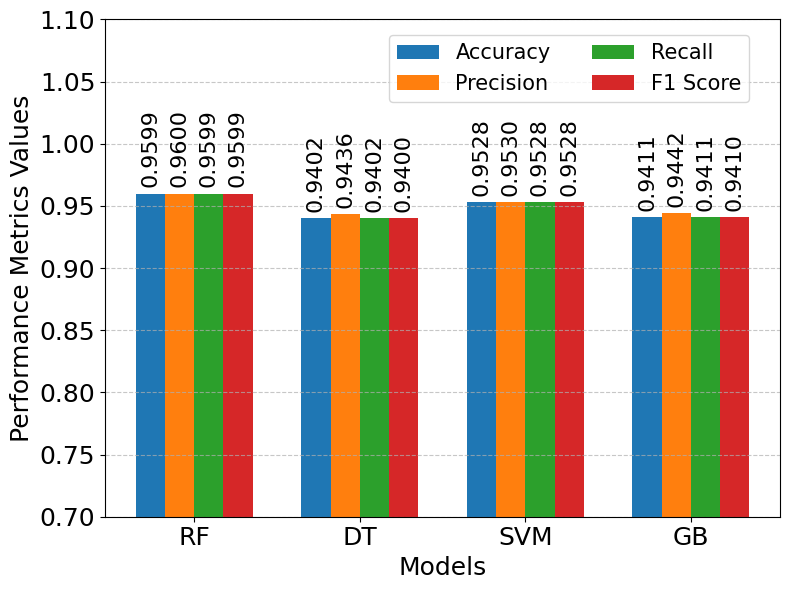

In [21]:
# Re-importing necessary libraries and re-defining the data
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = {
    "Accuracy": [0.9599, 0.9402, 0.9528, 0.9411],
    "Precision": [0.9600, 0.9436, 0.9530, 0.9442],
    "Recall": [0.9599, 0.9402, 0.9528, 0.9411],
    "F1 Score": [0.9599, 0.9400, 0.9528, 0.9410],
}
models = ["RF", "DT", "SVM", "GB"]

# Bar width and positions
bar_width = 0.12
spacing = 0.2

x = np.arange(len(models)) * (len(metrics) * bar_width + spacing)
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting bars for each metric
for i, (metric, values) in enumerate(metrics.items()):
    bars = ax.bar(x + i * bar_width, values, bar_width, label=metric)
    # Adding numerical values to each bar (vertically)
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f"{value:.4f}", 
                ha='center', va='bottom', rotation=90, fontsize=16)

# Customizing the plot
ax.set_xticks(x + bar_width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models, rotation=0, fontsize=18)
#ax.set_title("Comparison of Metrics Across Models", fontsize=18)
ax.set_ylabel("Performance Metrics Values", fontsize=18)  # Increased Y-axis font size
ax.set_xlabel("Models", fontsize=18)
ax.legend(loc="lower right", fontsize=18)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Setting the Y-axis to start from 0.5 with intervals of 0.05
ax.set_ylim(0.7, 1.09)
ax.set_yticks(np.arange(0.7, 1.1, 0.05))
ax.tick_params(axis='y', labelsize=18)  # Y-axis tick font size set to 14
plt.legend(title="", loc="upper right", bbox_to_anchor=(0.97, 0.99), ncol=2, frameon=True, fontsize=15)  # Legend inside the figure
# Adjust layout and show plot
plt.tight_layout()
plt.savefig('Comparison of Metrics Across Models.png')  # Save the plot
plt.show()

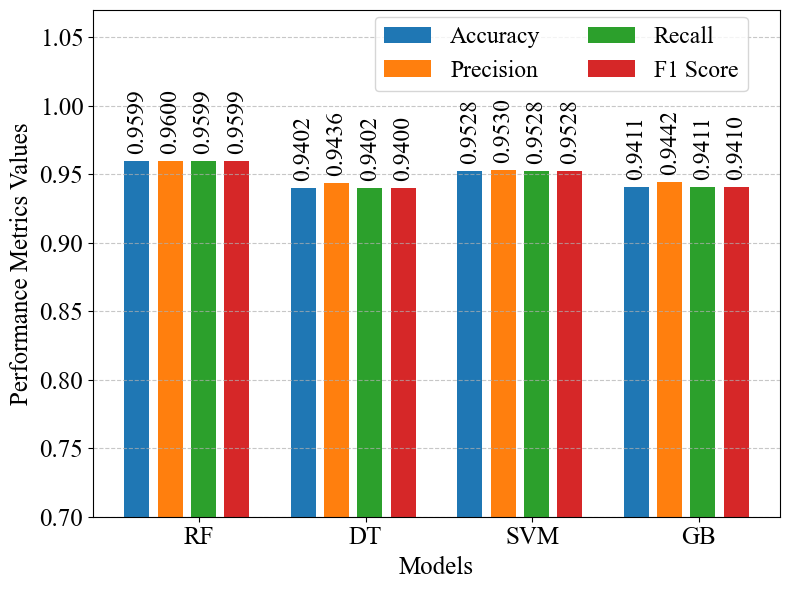

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Set Times New Roman font for all text
plt.rcParams["font.family"] = "Times New Roman"

# Data
metrics = {
    "Accuracy": [0.9599, 0.9402, 0.9528, 0.9411],
    "Precision": [0.9600, 0.9436, 0.9530, 0.9442],
    "Recall": [0.9599, 0.9402, 0.9528, 0.9411],
    "F1 Score": [0.9599, 0.9400, 0.9528, 0.9410],
}
models = ["RF", "DT", "SVM", "GB"]

# Bar width and positions
bar_width = 0.15  # Reduced width for smaller bars
bar_spacing = 0.05  # Additional spacing between bars for a single model
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(8, 6))

# Plotting bars for each metric with additional spacing
for i, (metric, values) in enumerate(metrics.items()):
    bars = ax.bar(x + i * (bar_width + bar_spacing), values, bar_width, label=metric)
    # Adding numerical values to each bar (vertically)
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f"{value:.4f}", 
                ha='center', va='bottom', rotation=90, fontsize=17)

# Customizing the plot
ax.set_xticks(x + (len(metrics) * (bar_width + bar_spacing) - bar_spacing) / 2)
ax.set_xticklabels(models, rotation=0, fontsize=18)
ax.set_ylabel("Performance Metrics Values", fontsize=18)
ax.set_xlabel("Models", fontsize=18)
ax.legend(loc="lower right", fontsize=18)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Setting the Y-axis to start from 0.7 with intervals of 0.05
ax.set_ylim(0.7, 1.07)
ax.tick_params(axis='y', labelsize=18)  # Y-axis tick font size set to 18
ax.set_yticks(np.arange(0.7, 1.07, 0.05))
plt.legend(title="", loc="upper right", bbox_to_anchor=(0.97, 1.01), ncol=2, frameon=True, fontsize=17)  # Legend inside the figure
plt.tight_layout()
plt.savefig('Comparison of Metrics Across Models.png')  # Save the plot
plt.show()